# Analyzing feature importance

[Advanced Uses of SHAP](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values)

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from src.dataset.data import Dataset
from src.dataset.utils import df_empty
from src.features.build_features import build_processed_dataset, convert_category_cols_lgb
from src.model.train import clf_xgb, clf_lgb
from src.visualization.model_visualizer import TreeVisualizer

from sklearn.model_selection import train_test_split

import altair as alt
alt.renderers.enable('notebook') # for the notebook only 

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [5]:
ds = Dataset()
ds.load_dataset("30000")
build_processed_dataset(ds)
convert_category_cols_lgb(ds)

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(ds.X_train, ds.y_train, test_size=0.3, random_state=0)

In [7]:
params = {
    'n_estimators': 500,
    'boosting_type': 'gbdt',
    'max_depth' : -1,
    'objective': 'binary',
    'nthread': -1, # Updated from nthread
    'num_leaves': 64,
    'learning_rate': 0.05,
    'max_bin': 512,
    'subsample_for_bin': 200,
    'subsample': 1,
    'subsample_freq': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 5,
    'reg_lambda': 10,
    'min_split_gain': 0.5,
    'min_child_weight': 1,
    'min_child_samples': 5,
    'scale_pos_weight': 1,
    'num_class' : 1,
    'metric' : 'auc'
}

In [9]:
clf, y_pred_valid, y_pred  = clf_lgb(X_train, y_train, X_valid, y_valid, ds.X_test, params)

[100]	training's auc: 0.97719	valid_1's auc: 0.91392
[200]	training's auc: 0.982137	valid_1's auc: 0.918931
[300]	training's auc: 0.982137	valid_1's auc: 0.918931
[400]	training's auc: 0.982137	valid_1's auc: 0.918931
[500]	training's auc: 0.982137	valid_1's auc: 0.918931


#### Quick model analysis

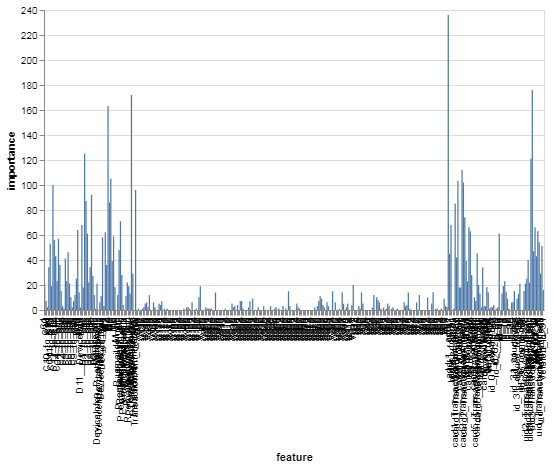

In [10]:
feature_importance = df_empty(['feature', 'importance'], dtypes=[str, float])
feature_importance['feature'] = ds.X_train.columns
feature_importance['importance'] = clf.feature_importances_
alt.Chart(feature_importance).mark_bar().encode(
        x='feature',
        y='importance',
        tooltip='feature'
    ).properties(width=500)

In [12]:
sample = X_valid.sample(5000, random_state=314)
visualizer = TreeVisualizer(clf, sample)

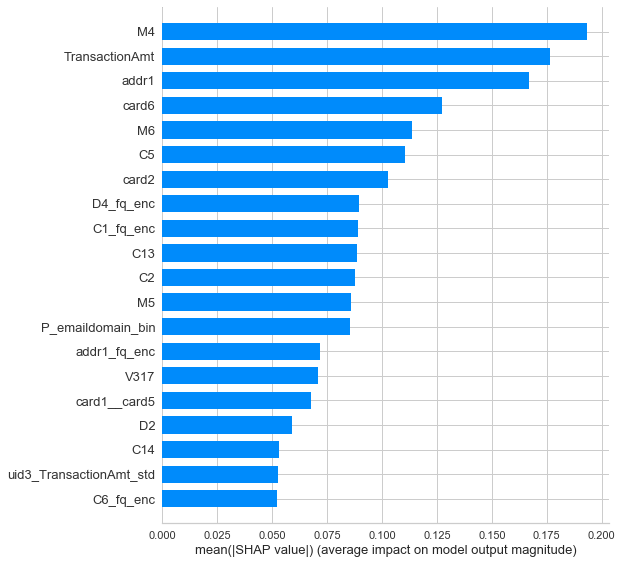

In [13]:
visualizer.summary_bar_plot()

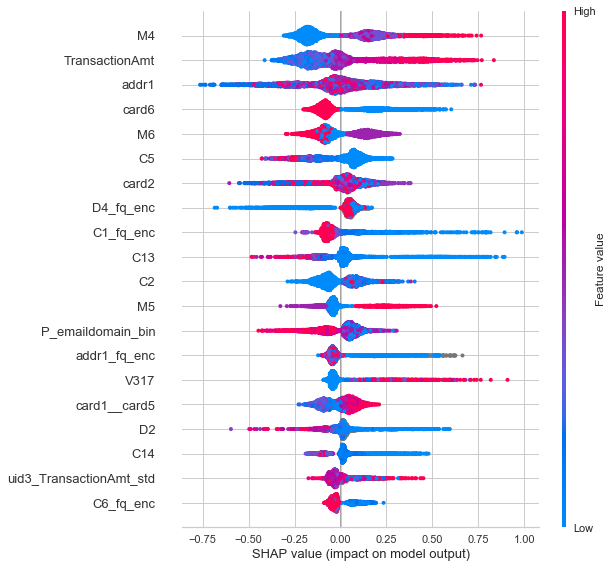

In [14]:
visualizer.summary_plot()

In [15]:
feature_importance = visualizer.get_importances()
feature_importance.head(25)

,column_name,shap_importance
33,M4,0.193558
0,TransactionAmt,0.176424
7,addr1,0.167151
6,card6,0.127359
35,M6,0.113848
14,C5,0.110601
3,card2,0.102525
348,D4_fq_enc,0.0895678
334,C1_fq_enc,0.0891214
20,C13,0.0885493


#### Maybe we can study those columns a bit 

In [16]:
feature_importance.iloc[0:10]

,column_name,shap_importance
33,M4,0.193558
0,TransactionAmt,0.176424
7,addr1,0.167151
6,card6,0.127359
35,M6,0.113848
14,C5,0.110601
3,card2,0.102525
348,D4_fq_enc,0.0895678
334,C1_fq_enc,0.0891214
20,C13,0.0885493


In [17]:
important_cols = feature_importance.iloc[0:7]['column_name'].values
important_cols

array(['M4', 'TransactionAmt', 'addr1', 'card6', 'M6', 'C5', 'card2'],
      dtype=object)

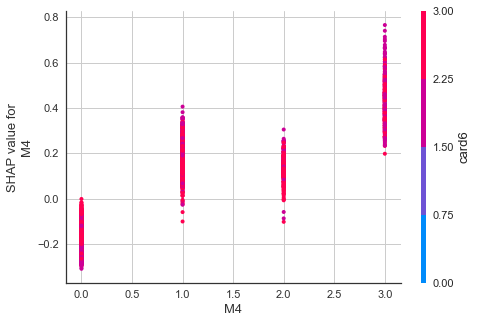

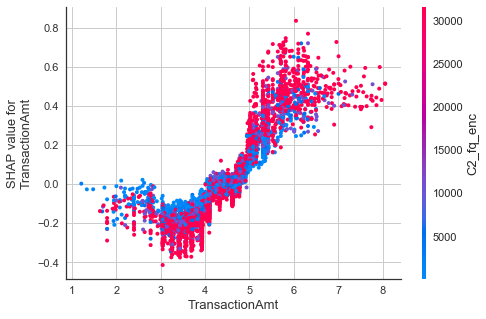

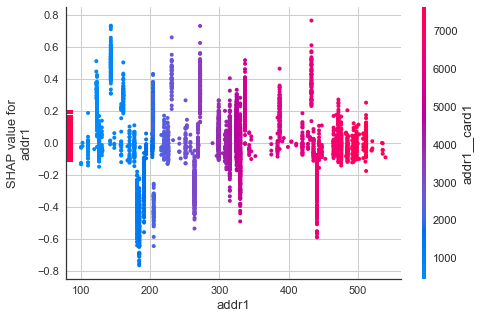

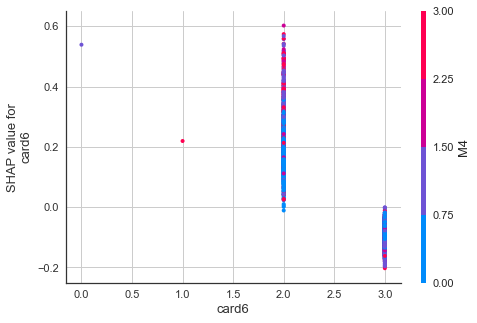

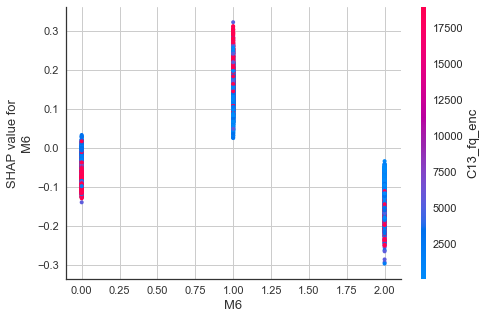

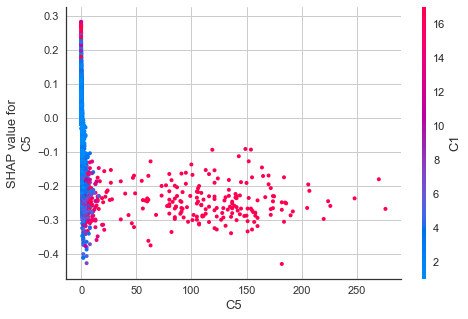

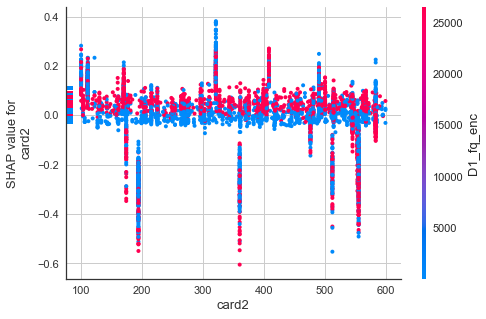

In [19]:
for name in important_cols:
    visualizer.dependence_plot(name)

#### Build a model on this sub selection, see if we can check interactions

In [20]:
ds = Dataset()
ds.load_dataset("30000")
build_processed_dataset(ds)
X_train_important, X_valid_important, y_train, y_valid = train_test_split(ds.X_train[important_cols], ds.y_train, test_size=0.3, random_state=0)

In [21]:
params = {
        "eta": 0.05,
        "max_depth": 9,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "gamma": 0.1,
        "subsample": 0.9,
        "colsample_bytree": 0.9,
        "verbosity": 0,
        "random_state": 1337,
        "nthread": -1,
    }

In [25]:
clf_important, y_imp_pred_valid, y_imp_pred = clf_xgb(X_train_important, y_train, X_valid_important, y_valid, ds.X_test[important_cols], params)

[0]	train-auc:0.805458	valid_data-auc:0.779629
[9]	train-auc:0.84228	valid_data-auc:0.823922


In [26]:
sample = X_valid_important.sample(1000, random_state=314)
visualizer_important = TreeVisualizer(clf_important, sample, interactions=True)

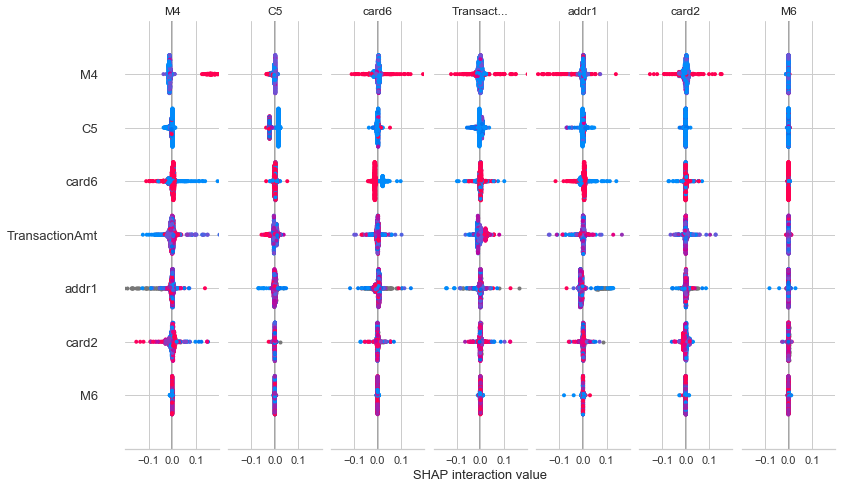

In [27]:
visualizer_important.interaction_summary_plot()

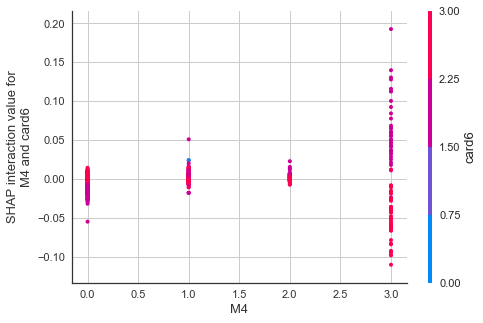

In [29]:
visualizer_important.interaction_dependence_plot(("M4", "card6"))

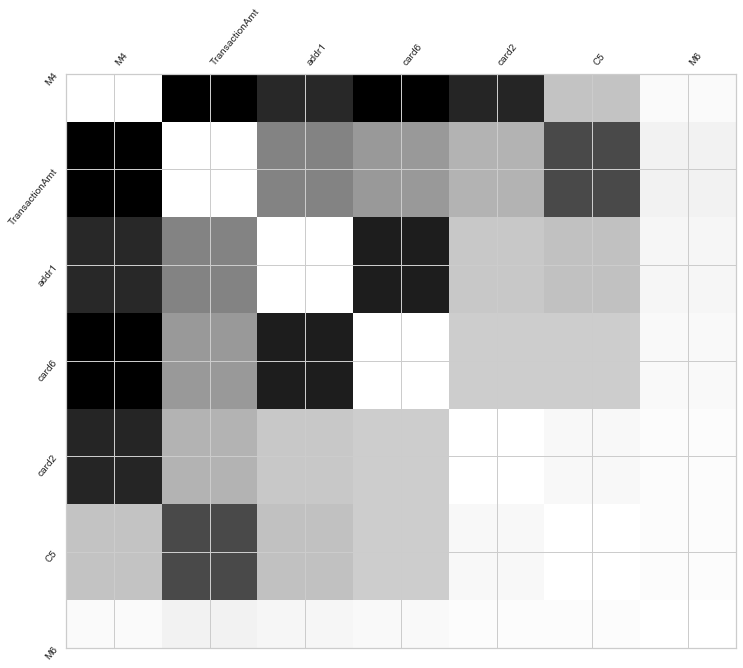

In [30]:
visualizer_important.interaction_matrix()